# Assignment 1 - PWM

In [1]:
from pynq.overlays.base import BaseOverlay
import time
base = BaseOverlay("base.bit")

### 1. Use the gpio.ipynb from lab as a starting point. Add a C++ function to reset all the GPIO pins on the chosen PMOD.

In [2]:
%%microblaze base.PMODB

#include <unistd.h>
#include "gpio.h"

// Function to write to a PMOD pin
int write_gpio(unsigned int pin, unsigned int val) {
    if (val > 1) {
        // Technically, an error, but just limit the user input to 1
        val = 1;
    }
    gpio pin_out = gpio_open(pin);
    gpio_set_direction(pin_out, GPIO_OUT);
    gpio_write(pin_out, val);

    return 0;
}

// Function to reset the PMOD pins
int reset_pins(void) {
    for (int i = 0; i < 8; i++)
        write_gpio(i, 0);
    return 0;
}

### 2. Write a Python3 cell that emulates a PWM (for a chosen frequency and duty cycle) on one of the PMOD GPIO pins.

In [3]:
pin_map = {
    'r': 3, # Red pin is connected to PMOD pin 3
    'g': 2, # Green pin is connected to PMOD pin 2
    'b': 1  # Blue pin is connected to PMOD pin 1
}

# freq in Hz, duty_cycle is fraction
def pwm(led = 'r', freq = 50, duty_cycle = 0.5, stop = True):
    try:
        pin = pin_map[led]
    except:
        print(f"'%c' is not supported. Please pass 'r', 'g' or 'b' as led parameter" % led)
        return

    if freq == 0:
        print("Cannot pass 0 as frequency")
        return

    if duty_cycle < 0.0 or duty_cycle > 1.0:
        print(f"Duty cycle %.2f not supported. Please pass a rational number between 0 & 1." % duty_cycle)
        return

    reset_pins()

    # Handle the 0% duty cycle input by just keeping the LED off
    if duty_cycle == 0.0:
        write_gpio(pin, 0)
        return;

    # Handle the 100% duty cycle input by just keeping the LED on
    if duty_cycle == 1.0:
        write_gpio(pin, 1)
        return;

    time_period = 1.0 / freq;

    # Time to turn on will be duty_cycle * (1/freq) seconds
    time_on = duty_cycle * time_period
    time_off = (1.0 - duty_cycle) * time_period

    print(f"Frequency: {freq} Hz, duty cycle: {duty_cycle * 100}%")
    print(f"Time on: %.2f ms, time off: %.2f ms" % (time_on * 1000, time_off * 1000))

    if not stop:
        while True:
            write_gpio(pin, 1)
            time.sleep(time_on)
            write_gpio(pin, 0)
            time.sleep(time_off)
    else:
        # Run it for a little bit before stopping
        i = 0
        while i < 250:
            write_gpio(pin, 1)
            time.sleep(time_on)
            write_gpio(pin, 0)
            time.sleep(time_off)
            i = i + 1
        reset_pins()

### 3. Find the optimal PWM frequency, such that the physical flashing phenonmenon will not be perceived visually

In [4]:
pwm('r', 25, 0.5)

Frequency: 25 Hz, duty cycle: 50.0%
Time on: 20.00 ms, time off: 20.00 ms


Observed flashing with 25 Hz & 50% duty cycle

In [5]:
pwm('r', 40, 0.5)

Frequency: 40 Hz, duty cycle: 50.0%
Time on: 12.50 ms, time off: 12.50 ms


Observed none/imperceptible flashing with 40 Hz & 50% duty cycle

In [6]:
pwm('r', 40, 0.1)

Frequency: 40 Hz, duty cycle: 10.0%
Time on: 2.50 ms, time off: 22.50 ms


Observed flashing with 40 Hz when reduced duty cycle to 10%

In [7]:
pwm('r', 50, 0.1)

Frequency: 50 Hz, duty cycle: 10.0%
Time on: 2.00 ms, time off: 18.00 ms


Observed no flashing with 50 Hz even with reduced duty cycle of 10%.

**50 Hz seems to be the optimal frequency.**

### 4. Achieve the visually perceived 100%, 75%, 50% and 25% of full LED brightness by adjusting the duty cycle

In [8]:
pwm('r', 50, 1.0)

In [9]:
pwm('r', 50, 0.75)

Frequency: 50 Hz, duty cycle: 75.0%
Time on: 15.00 ms, time off: 5.00 ms


In [10]:
pwm('r', 50, 0.5)

Frequency: 50 Hz, duty cycle: 50.0%
Time on: 10.00 ms, time off: 10.00 ms


In [11]:
pwm('r', 50, 0.25)

Frequency: 50 Hz, duty cycle: 25.0%
Time on: 5.00 ms, time off: 15.00 ms


### 5. Varying the duty cycles and approximate the corresponding LED brightness (in the unit of %). To the end, plot and explain the approximate relationship of % brightness versus duty cycle.

For this part, I decreased the duty cycle in increments of 10% and noting down the perceived brightness.

Frequency: 50 Hz, duty cycle: 99.0%
Time on: 19.80 ms, time off: 0.20 ms
Enter perceived brightness (0 - 100): 100
Frequency: 50 Hz, duty cycle: 89.0%
Time on: 17.80 ms, time off: 2.20 ms
Enter perceived brightness (0 - 100): 100
Frequency: 50 Hz, duty cycle: 79.0%
Time on: 15.80 ms, time off: 4.20 ms
Enter perceived brightness (0 - 100): 95
Frequency: 50 Hz, duty cycle: 69.0%
Time on: 13.80 ms, time off: 6.20 ms
Enter perceived brightness (0 - 100): 90
Frequency: 50 Hz, duty cycle: 59.0%
Time on: 11.80 ms, time off: 8.20 ms
Enter perceived brightness (0 - 100): 80
Frequency: 50 Hz, duty cycle: 49.0%
Time on: 9.80 ms, time off: 10.20 ms
Enter perceived brightness (0 - 100): 60
Frequency: 50 Hz, duty cycle: 39.0%
Time on: 7.80 ms, time off: 12.20 ms
Enter perceived brightness (0 - 100): 50
Frequency: 50 Hz, duty cycle: 28.999999999999996%
Time on: 5.80 ms, time off: 14.20 ms
Enter perceived brightness (0 - 100): 15
Frequency: 50 Hz, duty cycle: 19.0%
Time on: 3.80 ms, time off: 16.20 ms

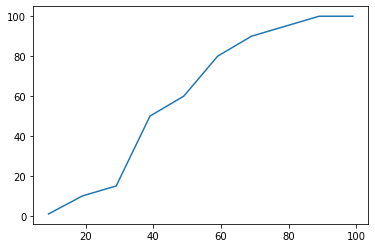

In [18]:
from matplotlib import pyplot

perceived_brightness = []

for duty_cycle in range(99, 1, -10):
    pwm('r', 50, duty_cycle / 100)
    user_in = input("Enter perceived brightness (0 - 100): ")
    perceived_brightness.insert(0, int(user_in))
    reset_pins()

duty_cycle = range(9, 100, 10)
pyplot.plot(duty_cycle, perceived_brightness)

### 6. For a fixed duty cycle (i.e. 25%), do the following:
- **Start the code and blink the LED’s red channel in intervals of 1 second (i.e. 1 second on, 1 second off)**
- **When buttons 0, 1, or 2 are pushed, the LED will change color from Red, to Green, to Blue.**
- **When button 3 is pushed, the LED will stop blinking.**


In [19]:
import asyncio

btns = base.btns_gpio
pins = list(pin_map.keys())
btn_pressed = 0

reset_pins()

async def control_led():
    global btn_pressed, pins
    while True:
        if btn_pressed == 0:
            write_gpio(pin_map['g'], 0)
            write_gpio(pin_map['b'], 0)

            write_gpio(pin_map['r'], 1)
            await asyncio.sleep(1)
            write_gpio(pin_map['r'], 0)
            await asyncio.sleep(1)

        elif btn_pressed == 1:
            write_gpio(pin_map['r'], 0)
            write_gpio(pin_map['b'], 0)

            write_gpio(pin_map['g'], 1)
            await asyncio.sleep(1)
            write_gpio(pin_map['g'], 0)
            await asyncio.sleep(1)

        elif btn_pressed == 2:
            write_gpio(pin_map['r'], 0)
            write_gpio(pin_map['g'], 0)

            write_gpio(pin_map['b'], 1)
            await asyncio.sleep(1)
            write_gpio(pin_map['b'], 0)
            await asyncio.sleep(1)

        elif btn_pressed == 3:
            reset_pins()

        await asyncio.sleep(0.01)

async def get_btn():
    global btn_pressed
    while True:
        await asyncio.sleep(0.01)
        btn_changed = False
        btns_in = btns.read()
        if btns_in == 0:
            continue
        else:
            for i in range(4):
                # btns.read() returns a bit mask with one-hot bit encoding
                # with the bit position corresponding to button pressed being set.
                if btns_in == (1 << i):
                    btn_pressed = i
                    break

loop = asyncio.new_event_loop()
loop.create_task(control_led())
loop.create_task(get_btn())
loop.run_forever()
loop.close()


KeyboardInterrupt

